In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import regex as re
import utilities.helpers as hp

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

import pyLDAvis.sklearn

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


# ALL cases topic modelling: 

# Import data set:

In [2]:
pd.options.mode.chained_assignment = None

df_full = hp.import_dataset(encoding='utf-8')
df_full.shape


(9635, 5)

# Dataset preprocessing:

All cases except for Unknown Homeland (Ukendt hjemland) are kept.

Below we see the shape and head of the dataset.

In [3]:
df_UH = df_full[df_full.country != "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_UH[['text']]

df["text"] = df["text"].astype(str)

df.shape

(9443, 1)

In [4]:

df.head()

,text
0,Nævnet omgjorde i maj 2022 Udlændinges...
1,Nævnet hjemviste i november 2021 Udlæn...
2,Nævnet omgjorde i maj 2022 Udlændinges...
3,Nævnet stadfæstede i maj 2022 Udlændin...
4,Nævnet stadfæstede i maj 2022 Udlændin...


Check for potential duplicates and drop them:

In [5]:
duplicates_df = df[df.duplicated(['text'], keep=False)]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

,text
131,Nævnet omgjorde i november 2021 Udlænd...
132,Nævnet omgjorde i november 2021 Udlænd...
133,Nævnet omgjorde i november 2021 Udlænd...
252,Nævnet omgjorde i november 2021 Udlænd...
521,Nævnet stadfæstede i juli 2021 Udlændi...
...,...
9595,Nævnet stadfæstede i december 2005 Udl...
9602,Nævnet stadfæstede i april 2004 en afg...
9603,Nævnet stadfæstede i april 2004 en afg...
9607,Nævnet meddelte i august 2004 opholdst...


New shape for dataset after droping duplicate entries.

In [6]:
# Drop duplicates from original dataframe:
df = df.drop_duplicates()

# Check shape again:
df.shape

(8963, 1)

# Use a pipeline to pre-process the texts:

The pipeline consists of the following steps:

- Lowercase all characters
- Drop numbers
- Remove punctuation
- Remove stopwords. The list of stopwords can be found [here](https://github.com/jethronap/AsylumData_KU/blob/main/misc/stopwords_dk.txt).
- Single letter words are dropped, too.
- Tokenization
- Lemmatization. The process during which all words are turned into its roots. 

Steps can be added or removed from the pipeline.

In [7]:
pipeline = [str.lower, hp.drop_numbers, hp.remove_punctuation, hp.remove_stopwords, hp.drop_single_letter_words,
            hp.tokenize, hp.lemmatize]


In [8]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(hp.process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [9]:
df.head()

,text,tokens,num_tokens
0,Nævnet omgjorde i maj 2022 Udlændinges...,"[omgjorde, udlændingestyrels, afgørelse, sag, ...",583
1,Nævnet hjemviste i november 2021 Udlæn...,"[hjemvise, udlændingestyrels, afgørelse, sag, ...",138
2,Nævnet omgjorde i maj 2022 Udlændinges...,"[omgjorde, udlændingestyrels, afgørelse, sag, ...",178
3,Nævnet stadfæstede i maj 2022 Udlændin...,"[stadfæste, udlændingestyrels, afgørelse, vedr...",545
4,Nævnet stadfæstede i maj 2022 Udlændin...,"[stadfæste, udlændingestyrels, afgørelse, vedr...",848


# Analysis:

In [10]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

In [11]:
# Use tf (raw term count) features for LDA.
count_text_vectorizer = CountVectorizer(min_df=2, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['tokens_joined'])

# Use tf-idf features for NMF and SVD
tfidf_text_vectorizer = TfidfVectorizer(min_df=2, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['tokens_joined'])
# tfidf_text_vectors.shape

## Topic Modelling:

### Latent Dirichlet Allocation (LDA):

In [12]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

best_num_LDA = float('NaN')
best_score_LDA = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create LDA model with i topics
    LDA_text_model = LatentDirichletAllocation(n_components=i, random_state=42)
    W_LDA_text_matrix = LDA_text_model.fit_transform(count_text_vectors)
    H_LDA_text_matrix = LDA_text_model.components_

    # Obtain the coherence score
    coherence_model_LDA = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_LDA_text_matrix, 
                        dtm=W_LDA_text_matrix, 
                        vocab=np.array([x for x in count_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_LDA = np.around(coherence_model_LDA, 2)
    for score in coherence_score_LDA:
        if score > best_score_LDA:
            best_num_LDA = i
            best_score_LDA = score

print(f'The coherence score for LDA ({best_score_LDA}) is highest with {best_num_LDA} topics.')

The coherence score for LDA (0.73) is highest with 3 topics.


Build the model with the best number of topics and see them:

In [13]:
LDA_model = LatentDirichletAllocation(n_components=best_num_LDA, random_state=42)
W_LDA_model_matrix = LDA_model.fit_transform(count_text_vectors)
H_LDA_model_matrix = LDA_model.components_

In [14]:
hp.display_topics(LDA_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 forklare (1.81)
 familie (1.15)
 myndighed (0.96)
 iran (0.90)
 udrejse (0.86)

Topic 01
 klager (2.65)
 syrien (1.64)
 opholdstilladelse (1.55)
 myndighed (1.43)
 meddele (1.00)

Topic 02
 klager (6.72)
 somalia (1.90)
 opholdstilladelse (1.74)
 alshabaab (1.33)
 danmark (1.28)


Visualise the topics produced by LDA:

In [15]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

LDA_display = pyLDAvis.sklearn.prepare(LDA_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

pyLDAvis.display(LDA_display)

/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [16]:
# pyLDAvis.save_html(LDA_display, 'LDA_ALL.html')

Each bubble in the plot represents a topic. The size of the bubble represents the proportion of cases that contain the topic, with a larger bubble corresponding to a higher proportion. 

The distance between the bubbles represents the similarity between the topics; the shorter the distance, the more similar the topics.

The bars in the bar chart represent the term frequency for each of the words. The blue bars show the overall term frequency in the collection of documents, whereas the red bars show the term frequency for the selected topic.

Finally, let's see how many documents could be assigned to each topic.

In [17]:
# Normalizing with the total sum and multiplying by 100 gives a percentage value
W_LDA_model_matrix.sum(axis=0)/W_LDA_model_matrix.sum()*100.0

array([63.52504972, 21.13795185, 15.33699843])

### Non-Negative Matrix Factorization:

In [18]:
warnings.filterwarnings("ignore", category=FutureWarning)

best_num_NMF = float('NaN')
best_score_NMF = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create NMF model with i topics
    NMF_text_model = NMF(n_components=i, random_state=42, max_iter=2000)
    W_NMF_text_matrix = NMF_text_model.fit_transform(tfidf_text_vectors)
    H_NMF_text_matrix = NMF_text_model.components_

    # Obtain the coherence score
    coherence_model_NMF = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_NMF_text_matrix, 
                        dtm=W_NMF_text_matrix, 
                        vocab=np.array([x for x in tfidf_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_NMF = np.around(coherence_model_NMF, 2)
    for score in coherence_score_NMF:
        if score > best_score_NMF:
            best_num_NMF = i
            best_score_NMF = score

print(f'The coherence score for NMF ({best_score_NMF}) is highest with {best_num_NMF} topics.')

The coherence score for NMF (0.74) is highest with 6 topics.


Build the model with the best number of topics and see them:

In [19]:
NMF_model = NMF(n_components=best_num_NMF, random_state=42, max_iter=2000)
W_NMF_model_matrix = NMF_model.fit_transform(tfidf_text_vectors)
H_NMF_model_matrix = NMF_model.components_

The numbers inside the parentheses are the percentages with which the words contribute to the topics.

In [20]:
hp.display_topics(NMF_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 klager (13.94)
 klagere (1.86)
 opholdstilladelse (1.75)
 danmark (1.04)
 syrien (0.97)

Topic 01
 iran (2.43)
 iransk (1.12)
 myndighed (0.78)
 forklare (0.68)
 aktivitet (0.68)

Topic 02
 afghanistan (2.62)
 taliban (2.31)
 forklare (0.71)
 familie (0.66)
 slå (0.51)

Topic 03
 somalia (4.46)
 alshabaab (3.11)
 mogadishu (0.90)
 mor (0.75)
 omskæring (0.63)

Topic 04
 irak (3.94)
 familie (0.74)
 bagdad (0.59)
 forklare (0.50)
 irakisk (0.50)

Topic 05
 syrien (1.66)
 libanon (1.28)
 syrisk (0.91)
 myndighed (0.68)
 palæstinenser (0.51)


Visualise the topics produced by NMF:

In [21]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


NMF_display = pyLDAvis.sklearn.prepare(NMF_model, tfidf_text_vectors, tfidf_text_vectorizer, sort_topics=False)

pyLDAvis.display(NMF_display)

In [22]:
# pyLDAvis.save_html(NMF_display, 'NMF_ALL.html')

Finally, let's see how many documents could be assigned to each topic.

In [23]:
# Normalizing with the total sum and multiplying by 100 gives a percentage value
W_NMF_model_matrix.sum(axis=0)/W_NMF_model_matrix.sum()*100.0

array([14.98205444, 19.57733991, 18.16001596, 11.35527382, 16.96343769,
       18.96187818])

### Latent Semantic Analysis/Indexing:

In [24]:
warnings.filterwarnings("ignore", category=FutureWarning)

best_num_SVD = float('NaN')
best_score_SVD = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create SVD model with i topics
    SVD_text_model = TruncatedSVD(n_components=i, random_state=42)
    W_SVD_text_matrix = SVD_text_model.fit_transform(tfidf_text_vectors)
    H_SVD_text_matrix = SVD_text_model.components_

    # Obtain the coherence score
    coherence_model_SVD = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_SVD_text_matrix, 
                        dtm=W_SVD_text_matrix, 
                        vocab=np.array([x for x in tfidf_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_SVD = np.around(coherence_model_SVD, 2)
    for score in coherence_score_SVD:
        if score > best_score_SVD:
            best_num_SVD = i
            best_score_SVD = score

print(f'The coherence score for SVD ({best_score_SVD}) is highest with {best_num_SVD} topics.')

The coherence score for SVD (0.72) is highest with 5 topics.


Build the model with the best number of topics and see them:

In [25]:
SVD_model = TruncatedSVD(n_components=best_num_SVD, random_state=42)
W_SVD_model_matrix = SVD_model.fit_transform(tfidf_text_vectors)
H_SVD_model_matrix = SVD_model.components_

In [26]:
hp.display_topics(SVD_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
 klager (2.60)
 opholdstilladelse (0.55)
 somalia (0.53)
 syrien (0.51)
 forklare (0.46)

Topic 01
 afghanistan (1.06)
 iran (1.02)
 taliban (0.82)
 forklare (0.81)
 irak (0.70)

Topic 02
 taliban (-18.68)
 afghanistan (-18.35)
 somalia (-6.69)
 alshabaab (-5.07)
 kabul (-3.63)

Topic 03
 somalia (23.70)
 alshabaab (16.51)
 irak (5.11)
 mogadishu (4.84)
 omskæring (3.50)

Topic 04
 irak (11.68)
 libanon (3.78)
 syrien (3.38)
 bagdad (2.01)
 palæstinenser (1.74)


Finally, let's see how many documents could be assigned to each topic.

In [27]:
# Normalizing with the total sum and multiplying by 100 gives a percentage value
W_SVD_model_matrix.sum(axis=0)/W_SVD_model_matrix.sum()*100.0

array([68.03498437, 28.29202527, -1.19778627,  1.58367399,  3.28710264])

In [28]:
# SVD_display = pyLDAvis.sklearn.prepare(SVD_model, tfidf_text_vectors, tfidf_text_vectorizer, sort_topics=False)

# pyLDAvis.display(SVD_display)

# Visualizations:

## Wordclouds:

## WordClouds from the LDA model:

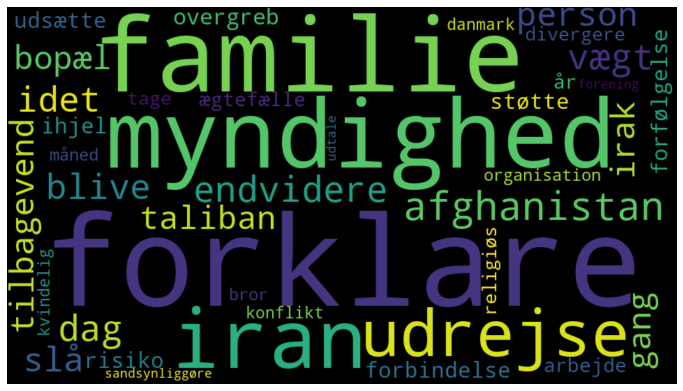

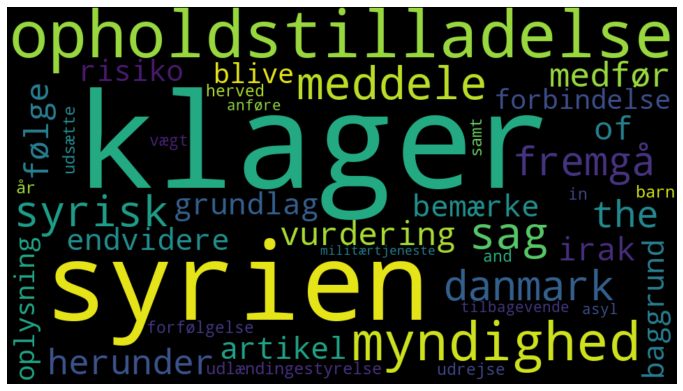

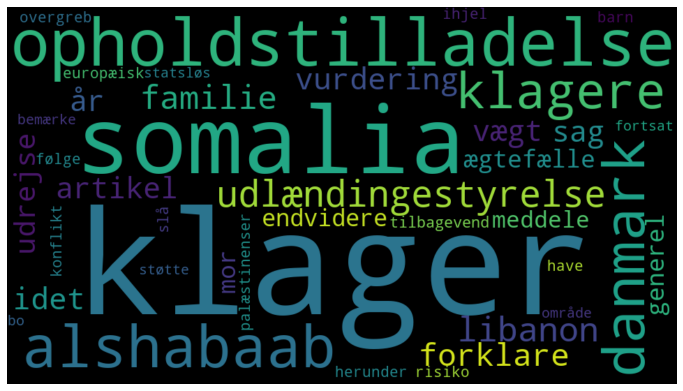

In [29]:
hp.wordcloud_topics(LDA_model, count_text_vectorizer.get_feature_names_out())

## WordClouds from the NMF model:

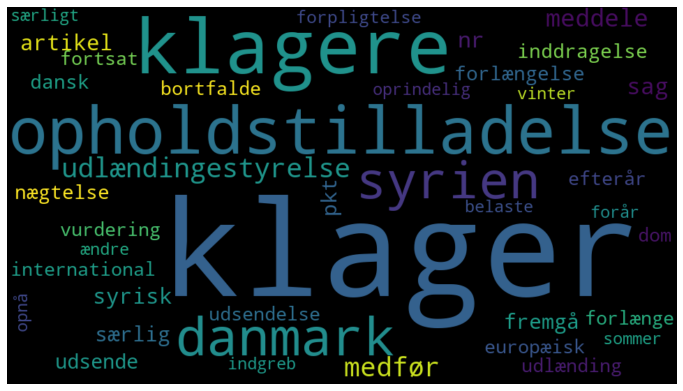

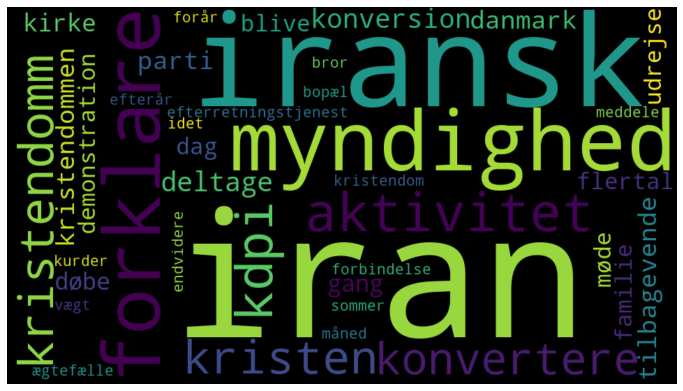

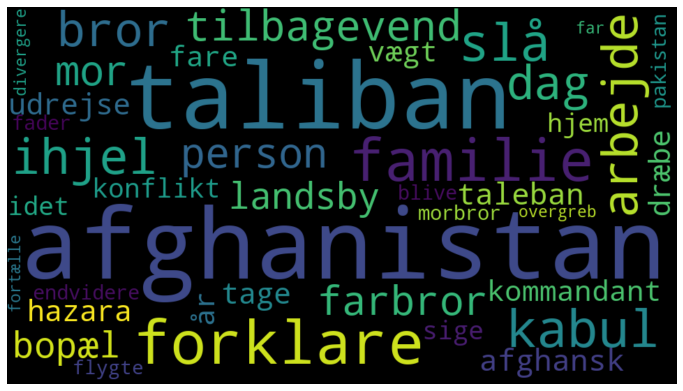

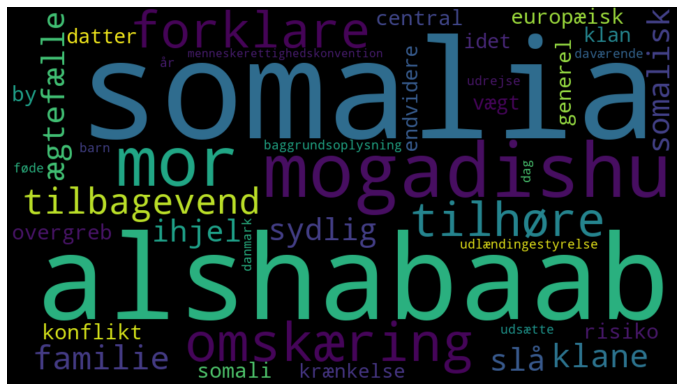

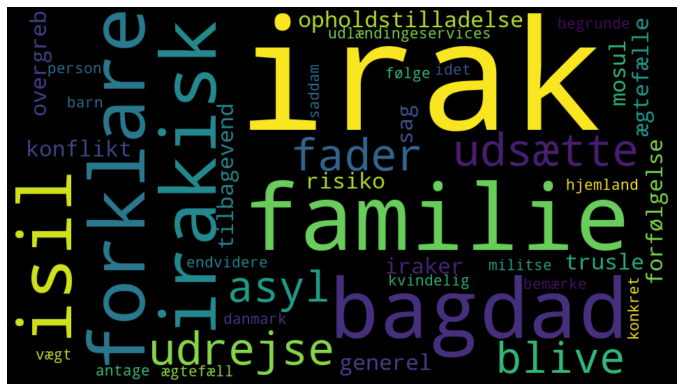

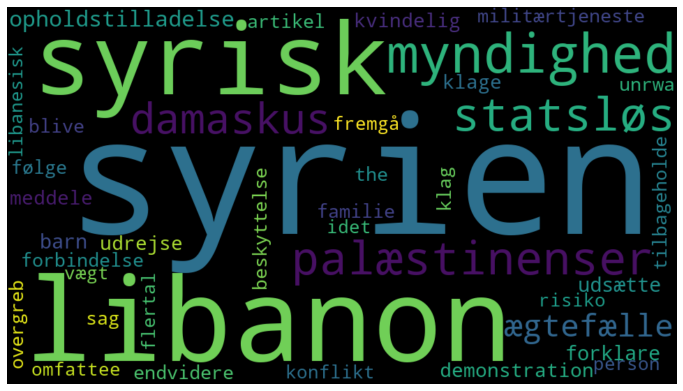

In [30]:
hp.wordcloud_topics(NMF_model, tfidf_text_vectorizer.get_feature_names_out())

## WordsClouds from the SVD model:

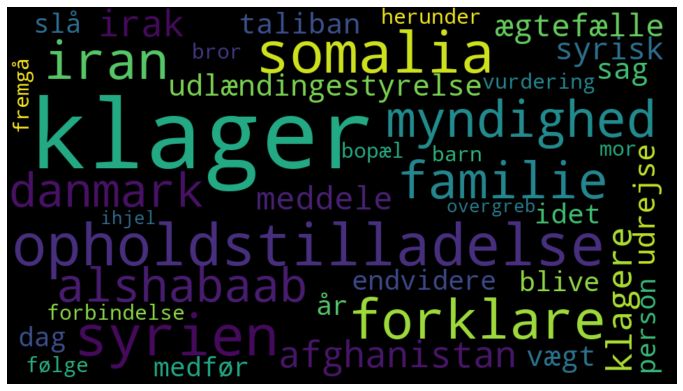

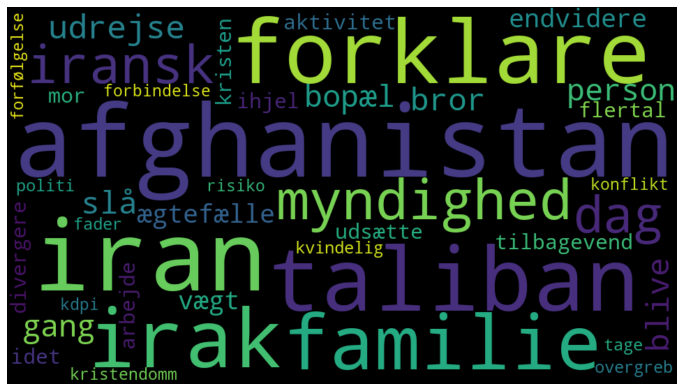

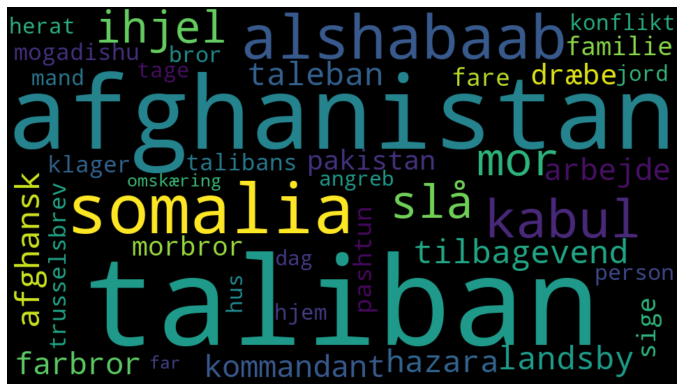

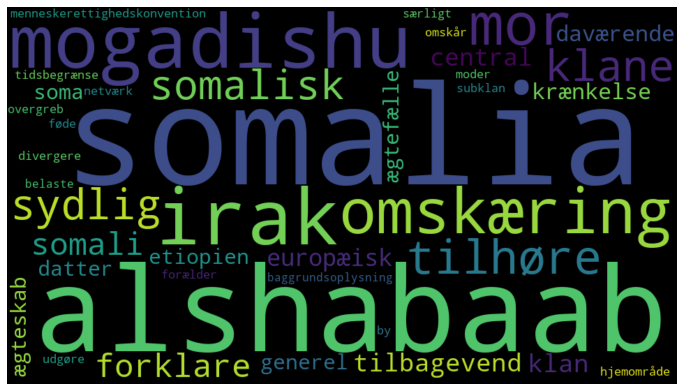

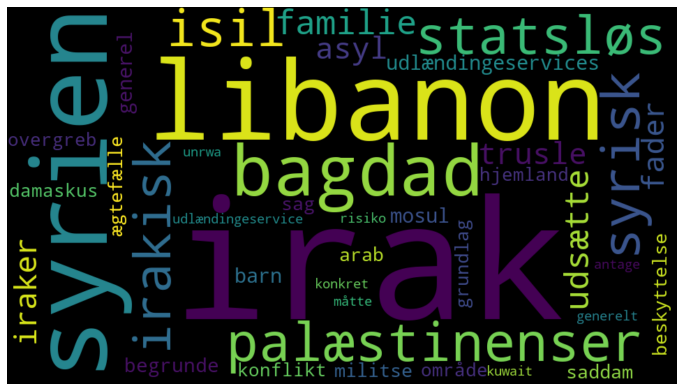

In [31]:
hp.wordcloud_topics(SVD_model, tfidf_text_vectorizer.get_feature_names_out())
